<a href="https://colab.research.google.com/github/MiroRavaProj/RoboLLM/blob/main/TimeSeriesForecasting/W2/outlier_detection_in_TS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Outlier detection for time series
In this groupwork we will try to remove pointwise outliers from three synthetic datasets using saliency scores $s_t$.

One way to produce saliency scores is to use a forecaster:
$$\hat{x}_{t+1} = f(x_{t|T})$$

then, for example, $s$ could be defined as
$$s_{t+1} = \begin{cases}
x_{t+1}-q_{0.99}   \quad \text{if} \quad x_{t+1}>q_{0.99}\\
q_{0.01} - x_{t+1} \quad \text{if} \quad x_{t+1}<q_{0.01}
\end{cases}$$

where $q_{0.99}$ and $q_{0.01}$ are the 99% and 1%, theoretic or empirical, quantiles of the predictions.

Feel free to use any other methods!


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
data = pd.read_csv('https://raw.githubusercontent.com/nepslor/teaching/main/TimeSeriesForecasting/data/outliers.csv', index_col=0)

[<Axes: >, <Axes: >, <Axes: >]

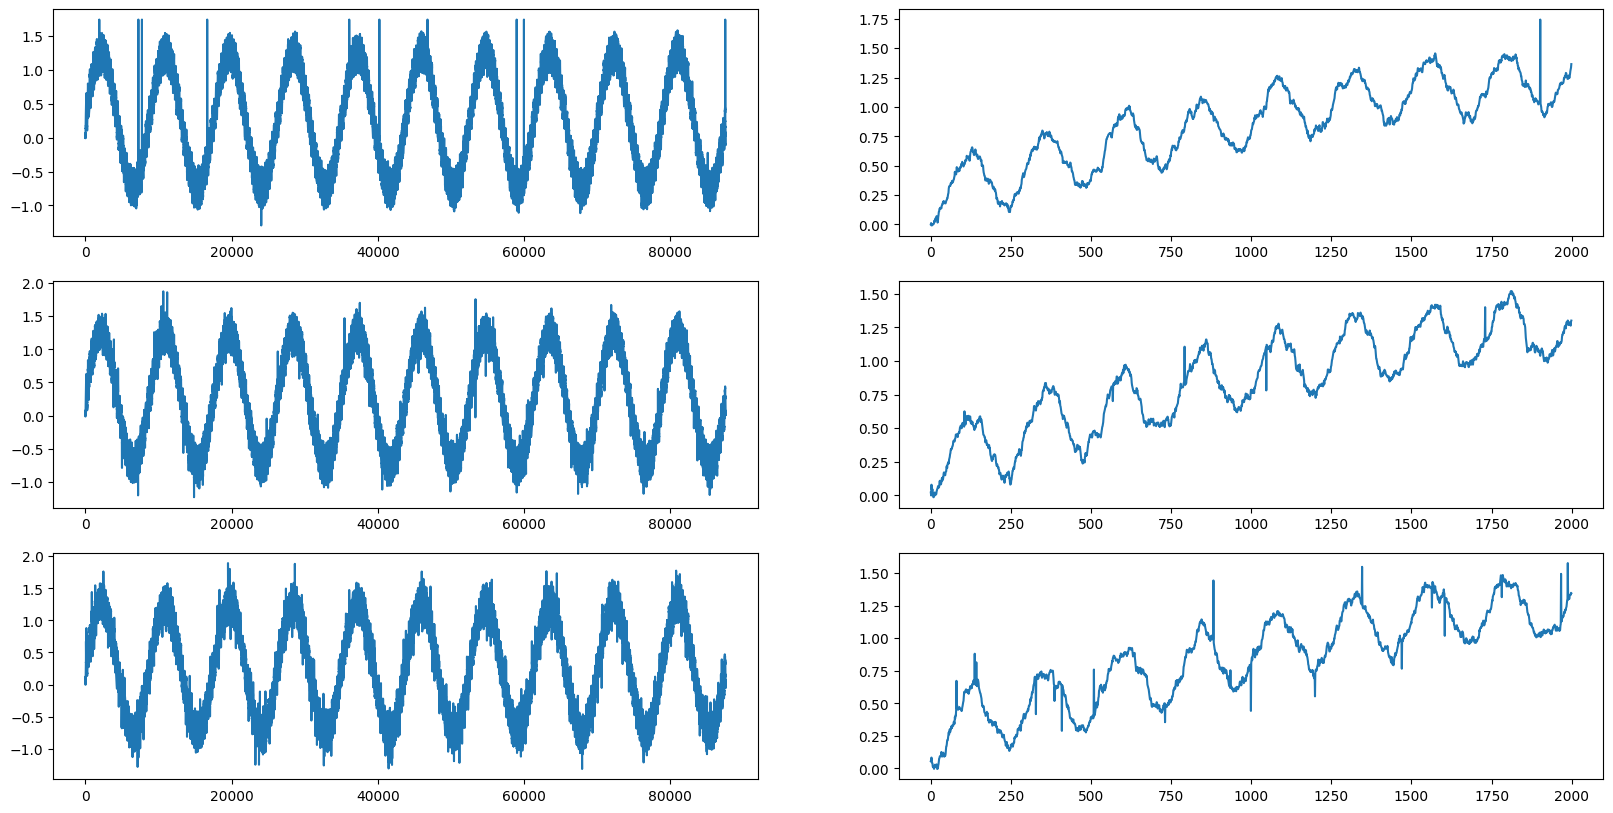

In [2]:
fig, ax = plt.subplots(3, 2, figsize=(20, 10))
[data[d].plot(ax=a) for d, a in zip(data, ax[:, 0])]
[data[d].iloc[:2000].plot(ax=a) for d, a in zip(data, ax[:, 1])]


The three datasets present the following characteristics:
1. Mostly out-of-distributions outliers: these outliers are higher or lower than the maximum observed values, and are easy to find. Watch out! Some other suspicious points could still be present!
2. Few local outliers. These cannot be filter out using a filter on the entire distribution, a sliding window method should be used.
3. A lot local outliers. Some methods could fail to spot those, since more than one could be present in the sliding window. Possibly an iterative method (in which outliers are spotted and replaced sequentially) could help.



# ❓ Your turn!
For this challenge you can reuse any technique or code we have seen in the previous exercises. The final evaluation metric is the $F1$ score, defined as:
$$F1 = 2/(1/precision + 1/recall)$$
Where
$$precision = TP/\hat{P}$$
$$recall = TP/P$$
That is, precision and recall are the ratio of points labeled as positive and being indeed positive (true positive) over the number of predicted positive points or effective positive points.


In [25]:
import pandas as pd

# Caricamento dei dati dal link fornito
data = pd.read_csv('https://raw.githubusercontent.com/nepslor/teaching/main/TimeSeriesForecasting/data/outliers.csv', index_col=0)

# Visualizzazione delle prime righe per verificare
print("Prime righe del dataset:")
print(data.head())

# Stampa delle informazioni sul dataset
print("\nInformazioni sul dataset:")
print(data.info())


Prime righe del dataset:
          0         1         2
0  0.001182  0.021295  0.055034
1  0.011919 -0.000174  0.057223
2 -0.008571  0.079687  0.083479
3 -0.007542  0.044413  0.055085
4  0.002404  0.036926  0.041715

Informazioni sul dataset:
<class 'pandas.core.frame.DataFrame'>
Index: 87600 entries, 0 to 87599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       87600 non-null  float64
 1   1       87600 non-null  float64
 2   2       87600 non-null  float64
dtypes: float64(3)
memory usage: 2.7 MB
None


In [38]:
# Selezione della prima serie temporale
first_series = data.iloc[:, 0]

# Dimensione della finestra
window_size = 15

# Dizionario per contare quante volte ogni punto è stato classificato come outlier
outlier_votes = {i: 0 for i in range(len(first_series))}

# Scorriamo la serie con una finestra mobile di dimensione 15 e slide di 1
for i in range(len(first_series) - window_size + 1):
    # Estrazione della finestra corrente
    window = first_series[i:i + window_size]

    # Calcolo della media e della deviazione standard della finestra
    mean = window.mean()
    std = window.std()

    # Controllo per gli outlier all'interno della finestra
    for j in range(window_size):
        if abs(window.iloc[j] - mean) > 2.85 * std:
            # Aggiungi un voto di outlier per l'indice globale
            outlier_votes[i + j] += 1

# Soglia di voto a maggioranza (almeno il 50% delle finestre deve considerarlo outlier)
vote_threshold = window_size // 2

# Identificazione degli outlier in base ai voti
outlier_indices = [index for index, votes in outlier_votes.items() if votes > vote_threshold]
outlier_values = [first_series.iloc[i] for i in outlier_indices]

# Creazione di un DataFrame per visualizzare gli outlier trovati
outliers_df = pd.DataFrame({
    'Index': outlier_indices,
    'Value': outlier_values
})

# Stampa del numero totale di outlier trovati e la lista
print(f"Numero totale di outlier rilevati (finestra 15): {len(outlier_indices)}")
print("Outlier trovati:")
print(outliers_df)


Numero totale di outlier rilevati (finestra 15): 19
Outlier trovati:
    Index     Value
0    1902  1.743629
1    7250  1.743629
2    7736  1.743629
3   16663  1.743629
4   24054 -1.296090
5   36088  1.743629
6   38284  1.060232
7   40209  1.743629
8   44992  1.106937
9   46791  1.743629
10  49265 -0.780599
11  50448 -1.088783
12  55549  1.198117
13  58988  1.743629
14  59980  1.743629
15  82212  1.000245
16  83001  0.829891
17  85119 -0.223227
18  87514  1.743629


In [37]:
import plotly.graph_objs as go
import plotly.offline as pyo

# Creazione della traccia per i dati originali
trace1 = go.Scatter(
    x=first_series.index,
    y=first_series,
    mode='lines',
    name='Dati Originali',
    line=dict(color='blue')
)

# Creazione della traccia per gli outlier
trace2 = go.Scatter(
    x=outliers_df['Index'],
    y=outliers_df['Value'],
    mode='markers',
    name='Outlier (Voto a Maggioranza, Finestra 15)',
    marker=dict(color='red', size=8, symbol='circle')
)

# Layout del grafico
layout = go.Layout(
    title='Serie Temporale con Outlier - Grafico Interattivo (Finestra 15)',
    xaxis=dict(title='Tempo'),
    yaxis=dict(title='Valori'),
    hovermode='closest'
)

# Creazione della figura
fig = go.Figure(data=[trace1, trace2], layout=layout)

# Visualizzazione interattiva del grafico
pyo.iplot(fig)


In [43]:
# Selezione della seconda serie temporale
second_series = data.iloc[:, 1]

# Dimensione della finestra
window_size = 15

# Dizionario per contare quante volte ogni punto è stato classificato come outlier
outlier_votes = {i: 0 for i in range(len(second_series))}

# Scorriamo la serie con una finestra mobile di dimensione 15 e slide di 1
for i in range(len(second_series) - window_size + 1):
    # Estrazione della finestra corrente
    window = second_series[i:i + window_size]

    # Calcolo della media e della deviazione standard della finestra
    mean = window.mean()
    std = window.std()

    # Controllo per gli outlier all'interno della finestra
    for j in range(window_size):
        if abs(window.iloc[j] - mean) > 2.5 * std:
            # Aggiungi un voto di outlier per l'indice globale
            outlier_votes[i + j] += 1

# Soglia di voto a maggioranza (almeno il 50% delle finestre deve considerarlo outlier)
vote_threshold = window_size // 2

# Identificazione degli outlier in base ai voti
outlier_indices = [index for index, votes in outlier_votes.items() if votes > vote_threshold]
outlier_values = [second_series.iloc[i] for i in outlier_indices]

# Creazione di un DataFrame per visualizzare gli outlier trovati
outliers_df = pd.DataFrame({
    'Index': outlier_indices,
    'Value': outlier_values
})

# Stampa del numero totale di outlier trovati e la lista
print(f"Numero totale di outlier rilevati nel secondo grafico (finestra 15): {len(outlier_indices)}")
print("Outlier trovati:")
print(outliers_df)


Numero totale di outlier rilevati nel secondo grafico (finestra 15): 280
Outlier trovati:
     Index     Value
0      105  0.625797
1      568  0.701986
2      792  1.107089
3     1047  0.781608
4     1730  1.401035
..     ...       ...
275  86057 -0.695562
276  86412 -0.905140
277  86432 -0.444790
278  86604 -0.664739
279  87000  0.179424

[280 rows x 2 columns]


In [44]:
import plotly.graph_objs as go
import plotly.offline as pyo

# Creazione della traccia per i dati originali
trace1 = go.Scatter(
    x=second_series.index,
    y=second_series,
    mode='lines',
    name='Dati Originali (Secondo Grafico)',
    line=dict(color='blue')
)

# Creazione della traccia per gli outlier
trace2 = go.Scatter(
    x=outliers_df['Index'],
    y=outliers_df['Value'],
    mode='markers',
    name='Outlier (Voto a Maggioranza, Finestra 15)',
    marker=dict(color='red', size=8, symbol='circle')
)

# Layout del grafico
layout = go.Layout(
    title='Serie Temporale con Outlier - Grafico Interattivo (Secondo Grafico, Finestra 15)',
    xaxis=dict(title='Tempo'),
    yaxis=dict(title='Valori'),
    hovermode='closest'
)

# Creazione della figura
fig = go.Figure(data=[trace1, trace2], layout=layout)

# Visualizzazione interattiva del grafico
pyo.iplot(fig)


In [47]:
# Selezione della terza serie temporale
third_series = data.iloc[:, 2]

# Dimensione della finestra
window_size = 15

# Dizionario per contare quante volte ogni punto è stato classificato come outlier
outlier_votes = {i: 0 for i in range(len(third_series))}

# Scorriamo la serie con una finestra mobile di dimensione 15 e slide di 1
for i in range(len(third_series) - window_size + 1):
    # Estrazione della finestra corrente
    window = third_series[i:i + window_size]

    # Calcolo della media e della deviazione standard della finestra
    mean = window.mean()
    std = window.std()

    # Controllo per gli outlier all'interno della finestra
    for j in range(window_size):
        if abs(window.iloc[j] - mean) > 2.5 * std:
            # Aggiungi un voto di outlier per l'indice globale
            outlier_votes[i + j] += 1

# Soglia di voto a maggioranza (almeno il 50% delle finestre deve considerarlo outlier)
vote_threshold = window_size // 2

# Identificazione degli outlier in base ai voti
outlier_indices = [index for index, votes in outlier_votes.items() if votes > vote_threshold]
outlier_values = [third_series.iloc[i] for i in outlier_indices]

# Creazione di un DataFrame per visualizzare gli outlier trovati
outliers_df = pd.DataFrame({
    'Index': outlier_indices,
    'Value': outlier_values
})

# Stampa del numero totale di outlier trovati e la lista
print(f"Numero totale di outlier rilevati nel terzo grafico (finestra 15): {len(outlier_indices)}")
print("Outlier trovati:")
print(outliers_df)


Numero totale di outlier rilevati nel terzo grafico (finestra 15): 700
Outlier trovati:
     Index     Value
0       80  0.672311
1      137  0.880169
2      328  0.416842
3      409  0.288604
4      509  0.758858
..     ...       ...
695  87038  0.391648
696  87279 -0.070607
697  87452  0.470958
698  87480  0.307044
699  87579 -0.047314

[700 rows x 2 columns]


In [48]:
import plotly.graph_objs as go
import plotly.offline as pyo

# Creazione della traccia per i dati originali
trace1 = go.Scatter(
    x=third_series.index,
    y=third_series,
    mode='lines',
    name='Dati Originali (Terzo Grafico)',
    line=dict(color='blue')
)

# Creazione della traccia per gli outlier
trace2 = go.Scatter(
    x=outliers_df['Index'],
    y=outliers_df['Value'],
    mode='markers',
    name='Outlier (Voto a Maggioranza, Finestra 15)',
    marker=dict(color='red', size=8, symbol='circle')
)

# Layout del grafico
layout = go.Layout(
    title='Serie Temporale con Outlier - Grafico Interattivo (Terzo Grafico, Finestra 15)',
    xaxis=dict(title='Tempo'),
    yaxis=dict(title='Valori'),
    hovermode='closest'
)

# Creazione della figura
fig = go.Figure(data=[trace1, trace2], layout=layout)

# Visualizzazione interattiva del grafico
pyo.iplot(fig)
